In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
#gather 3 sourcse of data

url_i = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'


df_i = pd.read_csv(url_i, delimiter = '\t') 

df_tae = pd.read_csv('twitter-archive-enhanced.csv')

df_list = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet=json.loads(line)
        t_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id': int(t_id),
                        'retweet_count': retweet_count,
                        'like_count': fav_count})
df_tj= pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count','like_count'])








In [3]:
#clean first data 
#delete rows with bad rating data (less than 10)
df_tae = df_tae.query('rating_numerator >= 10')

# clean retweeted or reply rows 
df_tae = df_tae[df_tae['retweeted_status_id'].isnull()]
df_tae = df_tae[df_tae['in_reply_to_status_id'].isnull()]

#filter data to be before 1th aug 2017.
df_tae['timestamp'] = pd.to_datetime(df_tae['timestamp'])
df_tae = df_tae[(df_tae['timestamp'] < '2017-08-01 00:00:00')]

#drop unuesed columns
df_tae.drop(columns =['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp',
           'in_reply_to_status_id','in_reply_to_user_id','rating_denominator'],inplace = True)




In [4]:
#clean second data

#decide most accurate dog type prediction if available 
df_i['type'] = df_i.p1[df_i['p1_dog'] == True]
df_i['type'].fillna(df_i.p2[df_i['p2_dog'] == True], inplace = True)
df_i['type'].fillna(df_i.p3[df_i['p3_dog'] == True], inplace = True)

#delete null type data


#delete un used columns
df_i.drop(df_i.columns[3:-1], axis = 1, inplace = True)

df_i['type'].isnull().sum()

#combine the 3 sources of data

df_ti = pd.merge(df_tae, df_i, how='left', on=['tweet_id'])
df_com = pd.merge(df_ti, df_tj, how='left', on=['tweet_id'])

#delete rows with null type values
df_com['type'].isnull().sum()
df_com = df_com[df_com['type'].notna()]





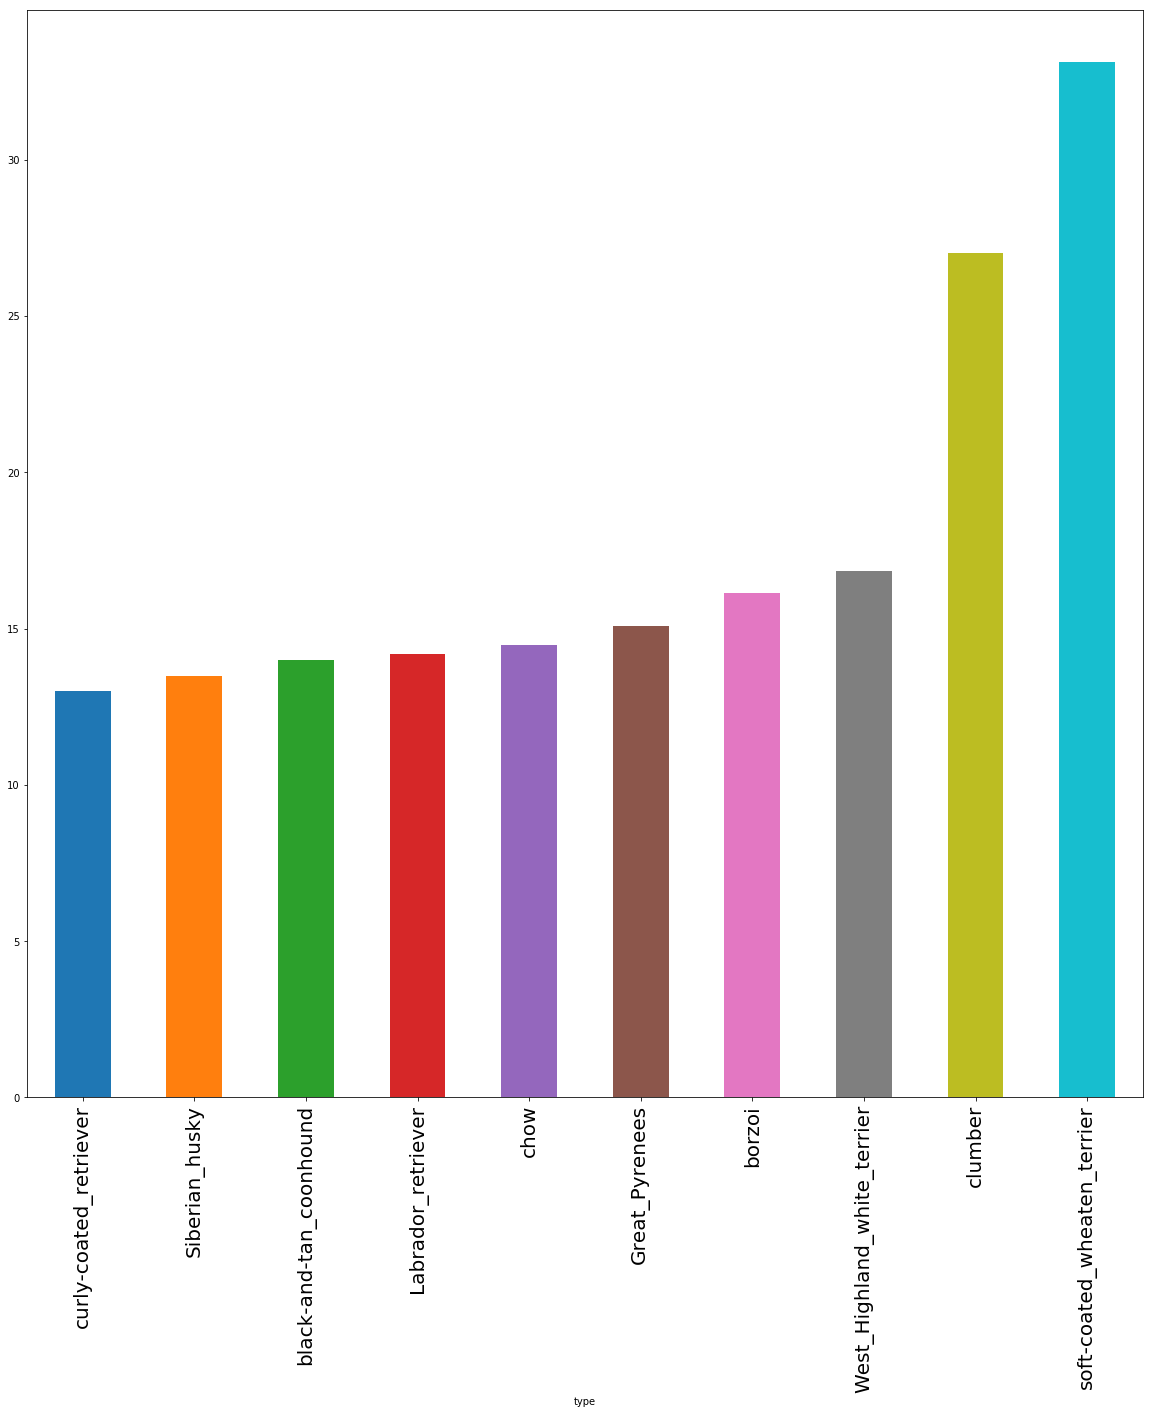

In [26]:
#top 10 dog types ratings

mean = df_com.groupby('type').mean().rating_numerator.sort_values()
plt.figure(figsize=(20,20))
plt.xticks(fontsize=20, rotation=90)
mean[-10:].plot.bar()

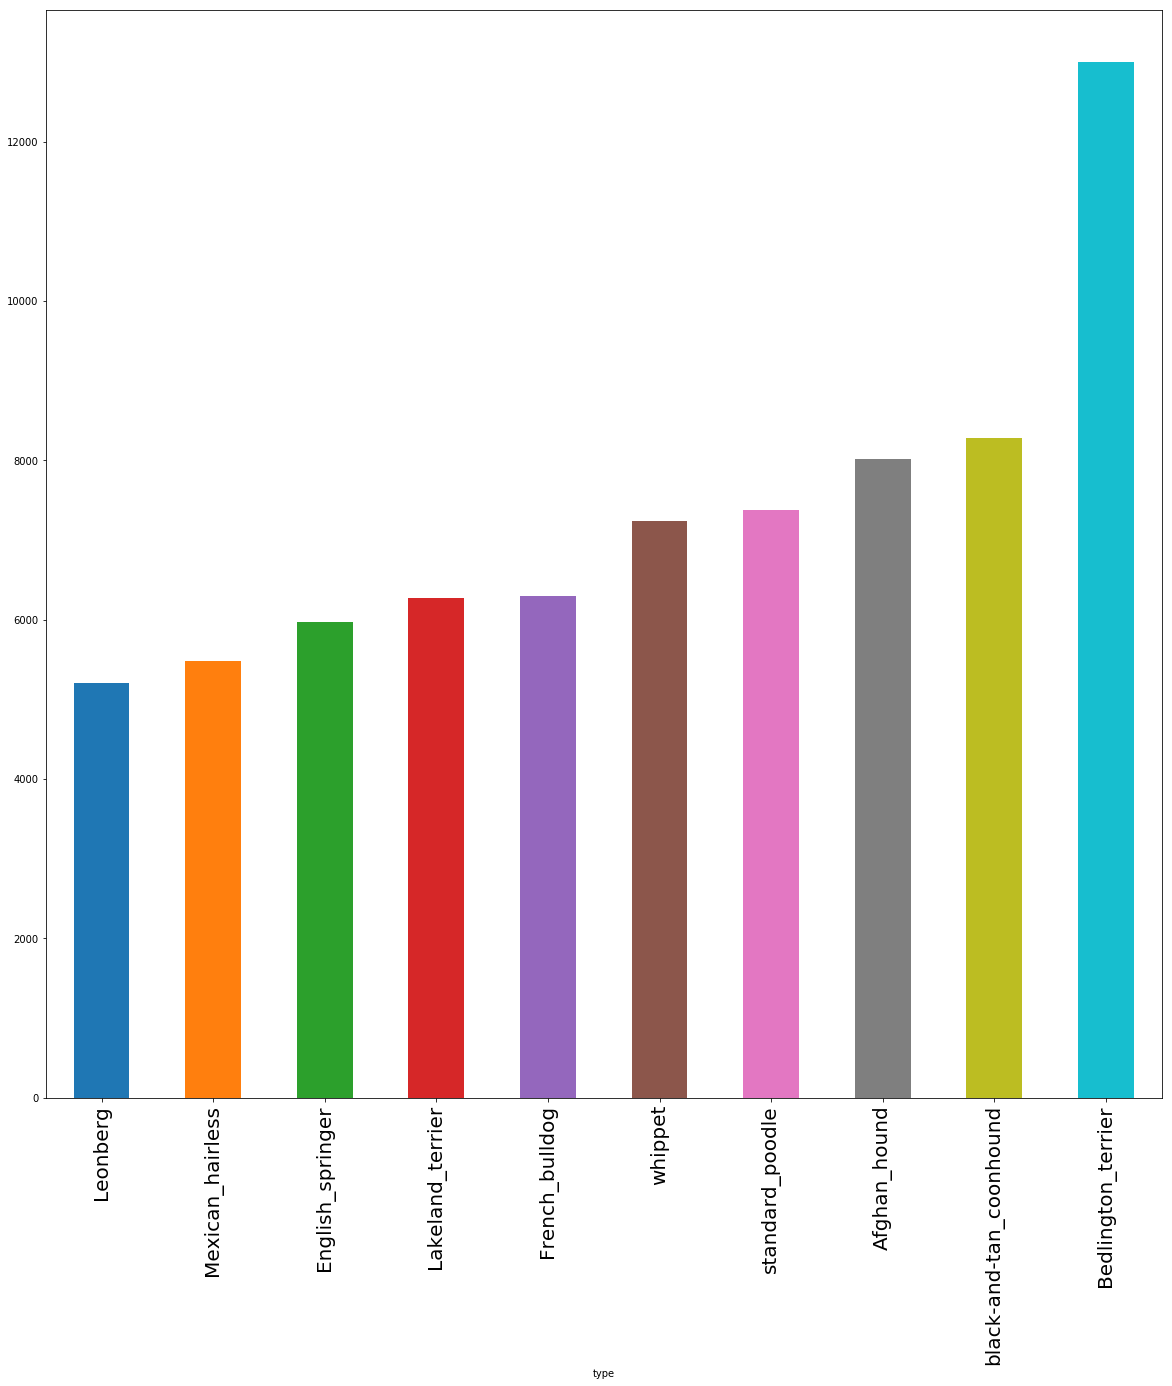

In [27]:
#top 10 dog types with high retweets numbers

mean = df_com.groupby('type').mean().retweet_count.sort_values()
plt.figure(figsize=(20,20))
plt.xticks(fontsize=20, rotation=90)
mean[-10:].plot.bar()

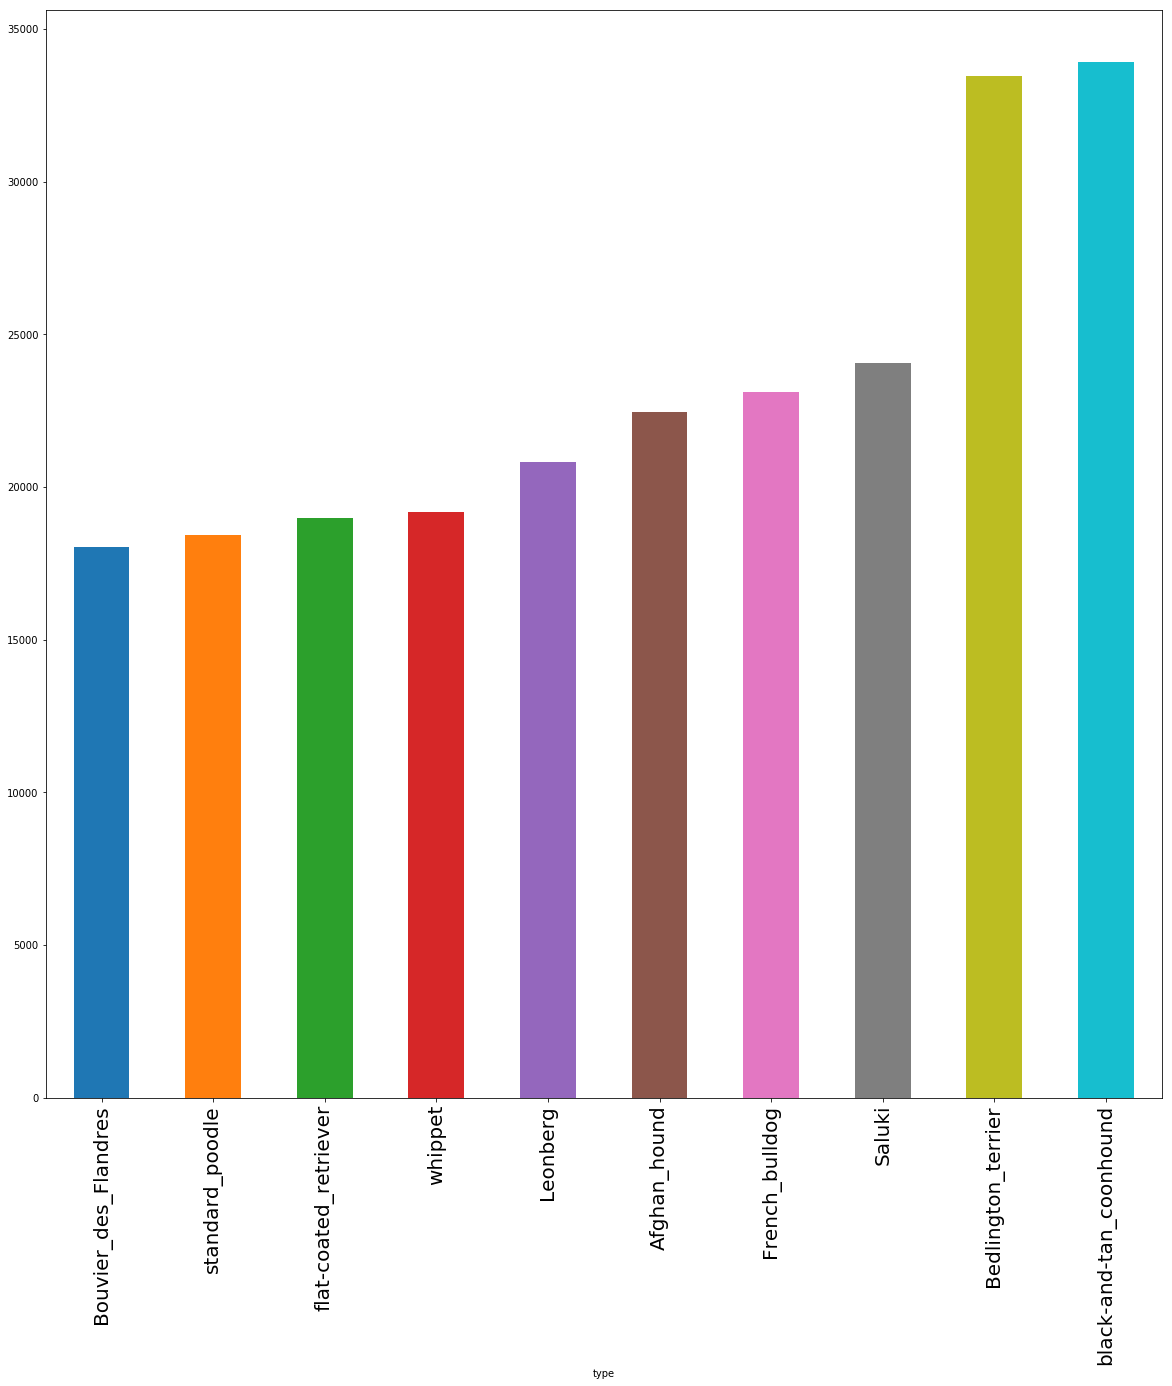

In [28]:
#top 10 dog types with like numbers

mean = df_com.groupby('type').mean().like_count.sort_values()
plt.figure(figsize=(20,20))
plt.xticks(fontsize=20, rotation=90)
mean[-10:].plot.bar()

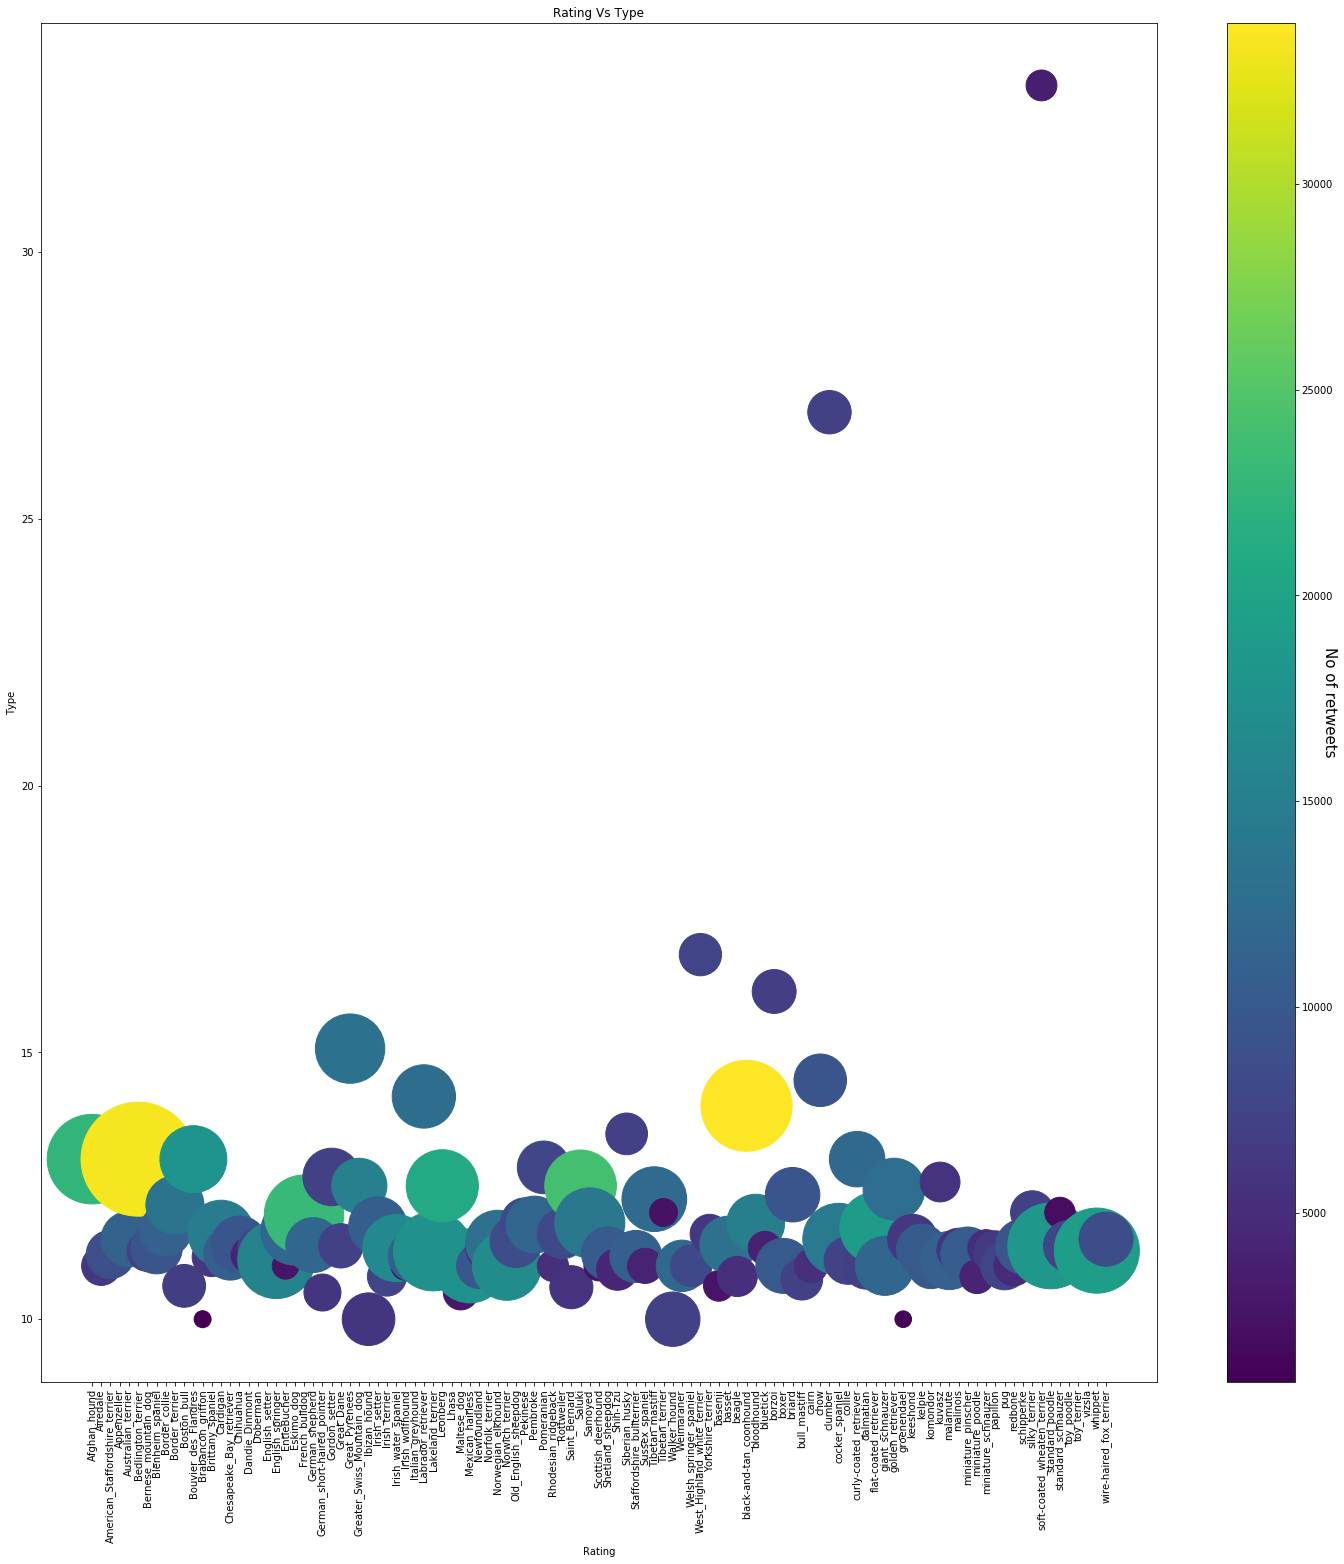

In [29]:
mean = df_com.groupby('type').mean()
plt.figure(figsize=(25,25))
plt.scatter(mean.index, mean.rating_numerator, s= mean.retweet_count ,c =mean.like_count)
plt.xlabel('Rating')
plt.ylabel('Type')
plt.xticks(rotation=90)
plt.title('Rating Vs Type')
plt.colorbar().set_label('No of retweets', rotation=270, size= 15)
plt.show()